In [1]:
import sys
sys.path.append('../')

import cv2
import numpy as np
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from equi_augmentation import image_projection_to_equi

figsize(5, 3)

In [5]:
equirectangular_image = cv2.imread("C:/Users/paulo/Pictures/test_faces/equi_images/image (11).JPG", cv2.IMREAD_COLOR)
image = cv2.imread("C:/Users/paulo/Pictures/test_faces/rick.png", cv2.IMREAD_COLOR)

In [15]:
phi = np.radians(15)
theta = np.radians(-120)

In [16]:
projected, interm_images = image_projection_to_equi(equirectangular_image.copy(), 
                                                                image, phi, theta, draw_intermediate = True)

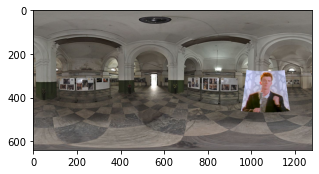

In [17]:
plt.imshow(cv2.cvtColor(projected, cv2.COLOR_BGR2RGB))
plt.show()

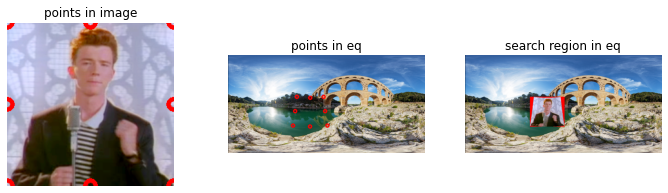

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

titles = ['points in image', 'points in eq', 'search region in eq']

for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.imshow(cv2.cvtColor(interm_images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.show()

In [7]:
lats = np.arange(-90,91,30)
longs = np.arange(-180, 181, 90)

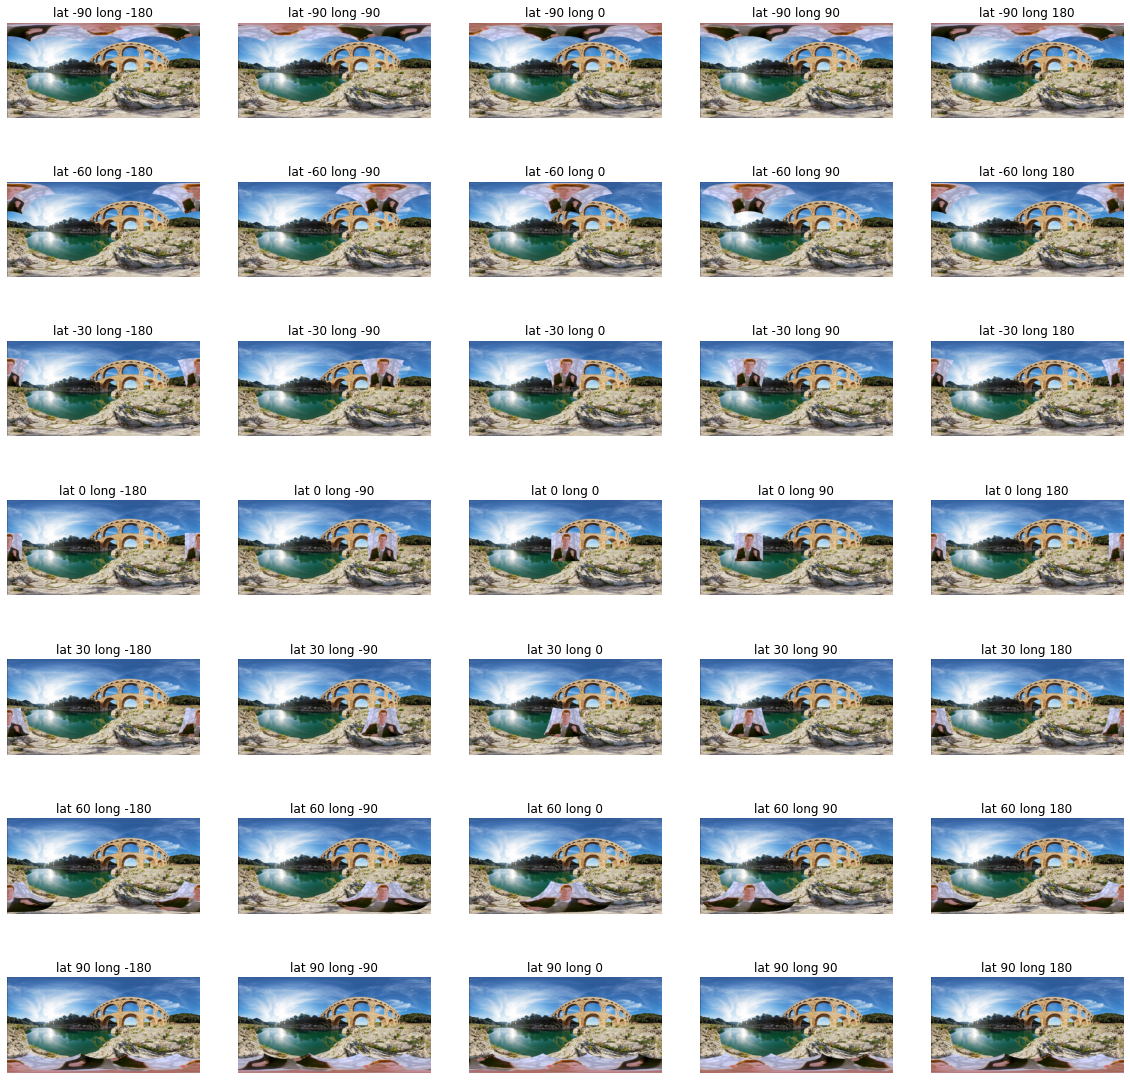

In [8]:
fig, axes = plt.subplots(nrows=len(lats), ncols=len(longs), figsize=(20, 20))

for i, lat in enumerate(lats):
    for j, long in enumerate(longs):

        projected, interm_images = image_projection_to_equi(equirectangular_image.copy(),image, 
                                                                    phi = np.radians(lat), theta = np.radians(long),
                                                                    draw_intermediate = False)
        title = f'lat {lat} long {long}'
        #cv2.imwrite(f'C:/Users/paulo/Pictures/test_faces/rick_rolled/{title}.png', projected)
        
        axes[i,j].set_title(title)
        axes[i,j].imshow(cv2.cvtColor(projected, cv2.COLOR_BGR2RGB))
        axes[i,j].axis('off')
        
plt.show()